## Packages

In [1]:
import os
import json
import math
# from google.colab import drive
import wave
import pathlib

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd


import tensorflow as tf 
from tensorflow.keras import layers, models
import tensorflow.keras as keras

import librosa
import IPython.display as display

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

2024-02-01 17:23:30.775367: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2024-02-01 17:23:30.933887: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-02-01 17:23:30.933977: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-02-01 17:23:30.959260: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-02-01 17:23:31.033800: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2024-02-01 17:23:31.034325: I tensorflow/core/platform/cpu_feature_guard.cc:1

# Mount google drive
adisamproject@gmail.com

In [2]:
# from google.colab import drive
# drive.mount('/content/drive')

# Audio Inspection and Properties

## On colab Notebooks
uncomment these lines for loading in data

### Load on audio file

In [3]:
# DATASET_PATH = "/content/drive/My Drive/2_Luganda/dataset/ddyo"
# example_audio_path = os.path.join(DATASET_PATH, 'Recording_162.wav')
# audio_signal, sample_rate = librosa.load(example_audio_path)

In [4]:
# audio = wave.open('/content/drive/My Drive/2_Luganda/dataset/ddyo/Recording_162.wav', 'rb')

In [5]:
# plt.figure(figsize=(12, 4))
# sns.histplot(audio_signal, bins=50, kde=True)
# plt.title('Amplitude Distribution')
# plt.xlabel('Amplitude')
# plt.ylabel('Frequency')
# plt.show()

## Locally

### Load on audio file


In [6]:
example_audio_path = 'dataset/backward/0165e0e8_nohash_0.wav'
audio_signal, sample_rate = librosa.load(example_audio_path)

In [7]:
audio = wave.open(example_audio_path, 'rb')

In [8]:
number_of_channel = audio.getnchannels()
sample_width = audio.getsampwidth()
frame_rate = audio.getframerate()
number_of_frames = audio.getnframes()

In [9]:
print('Number of channels:', number_of_channel)
print('Sample width:',       sample_width)
print('frame rate:',         frame_rate)
print('Number of frames:',   number_of_frames)
print('Parameters:',         audio.getparams())

Number of channels: 1
Sample width: 2
frame rate: 16000
Number of frames: 16000
Parameters: _wave_params(nchannels=1, sampwidth=2, framerate=16000, nframes=16000, comptype='NONE', compname='not compressed')


### Duration of the audio file

In [10]:
duration = librosa.get_duration(y=audio_signal, sr=sample_rate)
print(f"Duration: {duration} seconds")
print(f"Sample Rate: {sample_rate} Hz")

Duration: 1.0 seconds
Sample Rate: 22050 Hz


### Visualize the audio waveform

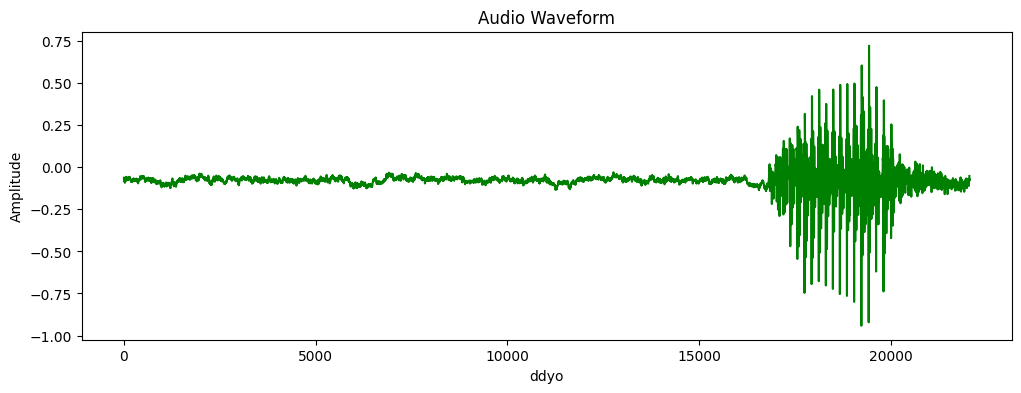

In [11]:
plt.figure(figsize=(12, 4))
plt.plot(audio_signal, color='green')
plt.title('Audio Waveform')
plt.xlabel('ddyo')
plt.ylabel('Amplitude')
plt.show()

### Amplitude Distribution

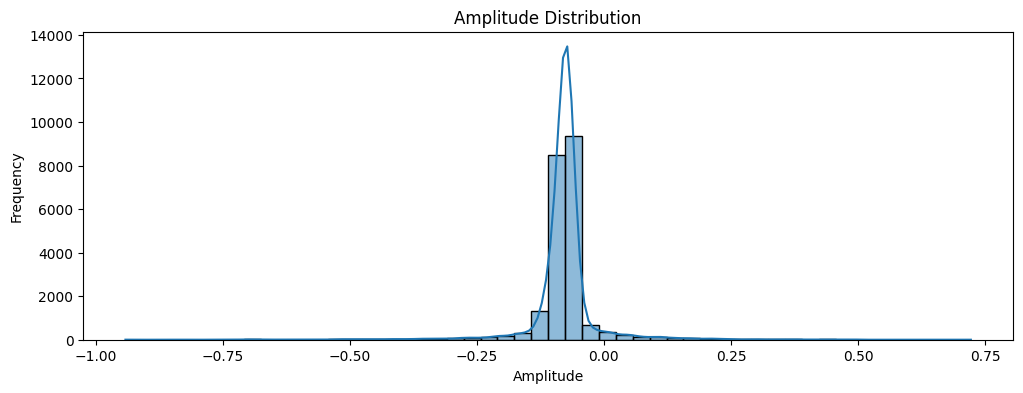

In [12]:
plt.figure(figsize=(12, 4))
sns.histplot(audio_signal, bins=50, kde=True)
plt.title('Amplitude Distribution')
plt.xlabel('Amplitude')
plt.ylabel('Frequency')
plt.show()


# Loading Raw Audio Data

The dataset's audio clips are of 6 classes and stored in six folders corresponding to each speech command: 
- `right`
- `backward`
- `no`
- `forward`
- `left`
- `stop`

### Set the seed value 

In [13]:
seed = 42
tf.random.set_seed(seed)
np.random.seed(seed)

In [14]:
DATASET_PATH = 'dataset/'
data_dir = pathlib.Path(DATASET_PATH)

In [15]:
commands = np.array(tf.io.gfile.listdir(str(data_dir)))
print('Commands:', commands)

Commands: ['right' 'backward' 'no' 'forward' 'left' 'stop']


# Split into Train and validation

In [16]:
train_ds, val_ds = tf.keras.utils.audio_dataset_from_directory(
    directory=data_dir,
    batch_size=64,
    validation_split=0.2,
    seed=0,
    output_sequence_length=16000,
    subset='both')

label_names = np.array(train_ds.class_names)
print()
print("label names:", label_names)

Found 6000 files belonging to 6 classes.
Using 4800 files for training.
Using 1200 files for validation.

label names: ['backward' 'forward' 'left' 'no' 'right' 'stop']


### The audio clips have a shape of `(batch, samples, channels)`.

In [17]:
train_ds.element_spec

(TensorSpec(shape=(None, 16000, None), dtype=tf.float32, name=None),
 TensorSpec(shape=(None,), dtype=tf.int32, name=None))

In [18]:
def squeeze(audio, labels):
  audio = tf.squeeze(audio, axis=-1)
  return audio, labels

train_ds = train_ds.map(squeeze, tf.data.AUTOTUNE)
val_ds = val_ds.map(squeeze, tf.data.AUTOTUNE)

In [19]:
test_ds = val_ds.shard(num_shards=2, index=0)
val_ds = val_ds.shard(num_shards=2, index=1)

In [20]:
for example_audio, example_labels in train_ds.take(1):
  print(example_audio.shape)
  print(example_labels.shape)

(64, 16000)
(64,)


### Plot a few audio waveforms:

In [21]:
label_names[[1,2,3,0,4,5]]

array(['forward', 'left', 'no', 'backward', 'right', 'stop'], dtype='<U8')

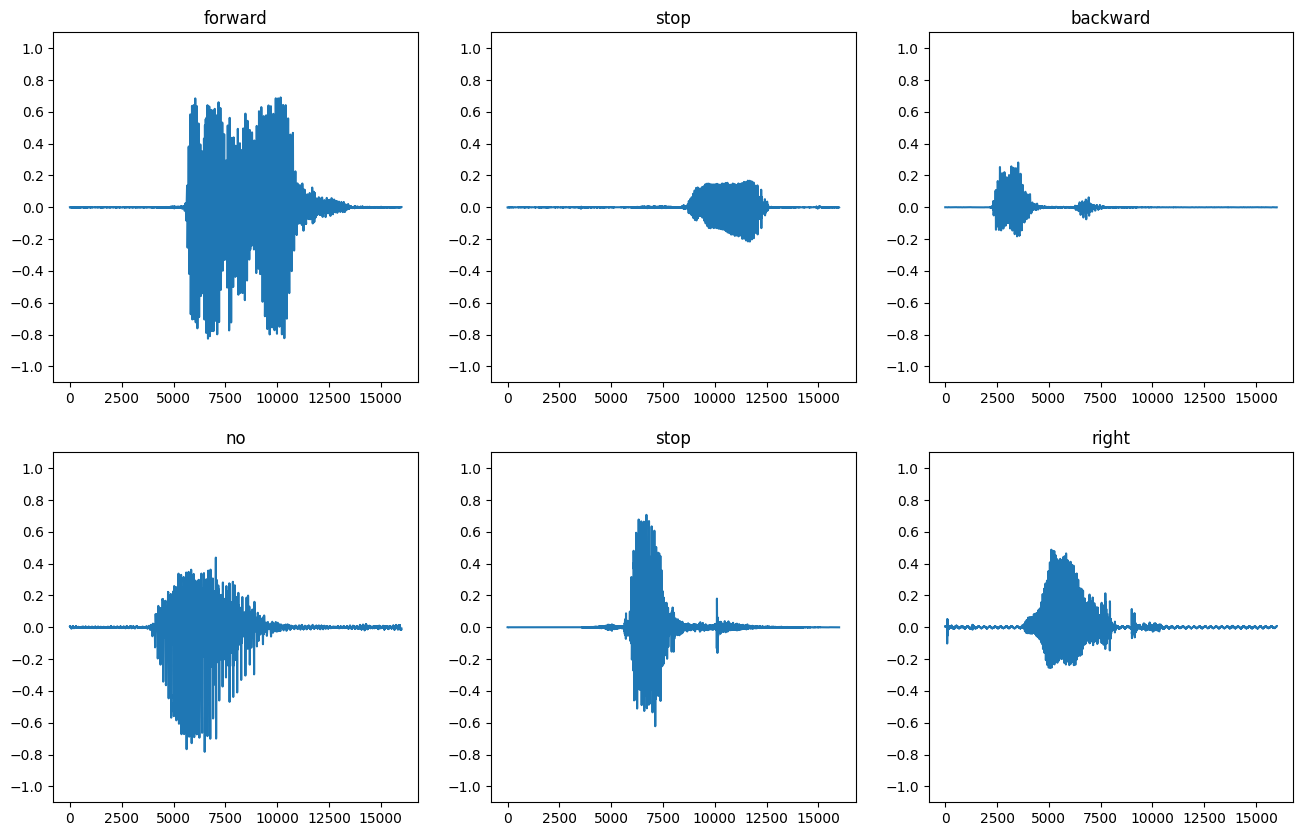

In [22]:
plt.figure(figsize=(16, 10))
rows = 2
cols = 3
n = rows * cols
for i in range(n):
  plt.subplot(rows, cols, i+1)
  audio_signal = example_audio[i]
  plt.plot(audio_signal)
  plt.title(label_names[example_labels[i]])
  plt.yticks(np.arange(-1.2, 1.2, 0.2))
  plt.ylim([-1.1, 1.1])

In [23]:
def get_spectrogram(waveform):
  # Convert the waveform to a spectrogram via a STFT.
  spectrogram = tf.signal.stft(
      waveform, frame_length=255, frame_step=128)
  # Obtain the magnitude of the STFT.
  spectrogram = tf.abs(spectrogram)
  # Add a `channels` dimension, so that the spectrogram can be used
  # as image-like input data with convolution layers (which expect
  # shape (`batch_size`, `height`, `width`, `channels`).
  spectrogram = spectrogram[..., tf.newaxis]
  return spectrogram

### The shapes of a tensorized waveform and the corresponding spectrogram, and play the original audio:

In [24]:
for i in range(3):
  label = label_names[example_labels[i]]
  waveform = example_audio[i]
  spectrogram = get_spectrogram(waveform)

  print('Label:', label)
  print('Waveform shape:', waveform.shape)
  print('Spectrogram shape:', spectrogram.shape)
  print('Audio playback')
  display.display(display.Audio(waveform, rate=16000))

Label: forward
Waveform shape: (16000,)
Spectrogram shape: (124, 129, 1)
Audio playback


Label: stop
Waveform shape: (16000,)
Spectrogram shape: (124, 129, 1)
Audio playback


Label: backward
Waveform shape: (16000,)
Spectrogram shape: (124, 129, 1)
Audio playback


### Displaying a spectrogram:

In [25]:
# Convert the frequencies to log scale and transpose, so that the time is
# represented on the x-axis (columns).
# Add an epsilon to avoid taking a log of zero.

def plot_spectrogram(spectrogram, ax):
  if len(spectrogram.shape) > 2:
    assert len(spectrogram.shape) == 3
    spectrogram = np.squeeze(spectrogram, axis=-1)
      
  log_spec = np.log(spectrogram.T + np.finfo(float).eps)
  height = log_spec.shape[0]
  width = log_spec.shape[1]
  X = np.linspace(0, np.size(spectrogram), num=width, dtype=int)
  Y = range(height)
  ax.pcolormesh(X, Y, log_spec)

### Plot of waveform over time and the corresponding spectrogram.

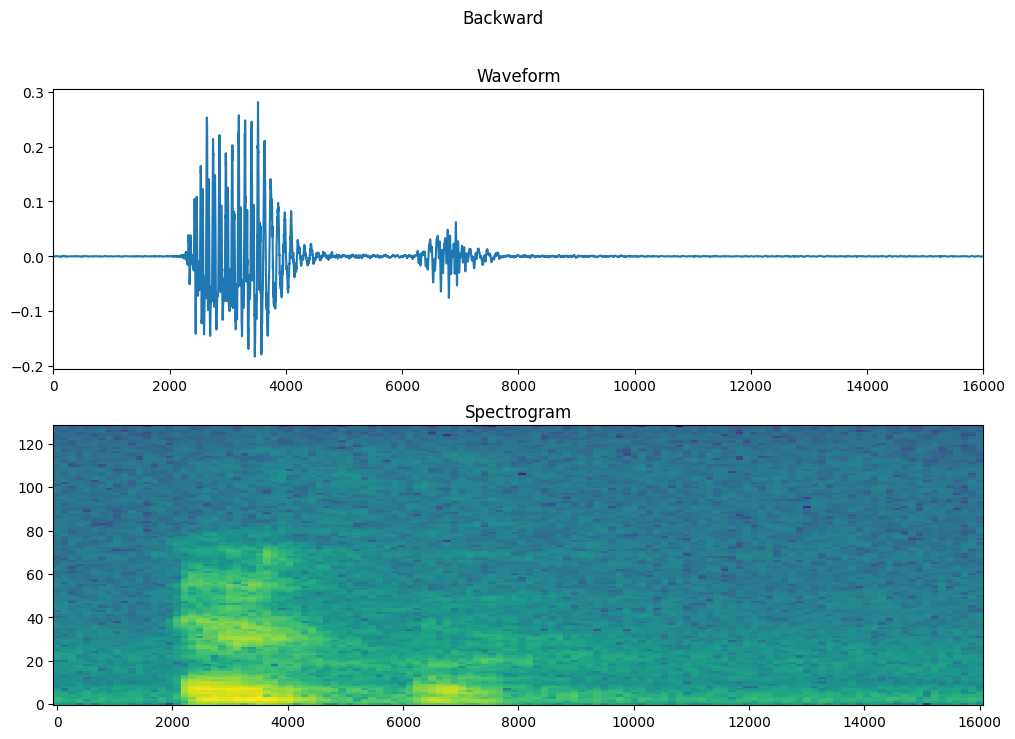

In [26]:
fig, axes = plt.subplots(2, figsize=(12, 8))
timescale = np.arange(waveform.shape[0])
axes[0].plot(timescale, waveform.numpy())
axes[0].set_title('Waveform')
axes[0].set_xlim([0, 16000])

plot_spectrogram(spectrogram.numpy(), axes[1])
axes[1].set_title('Spectrogram')
plt.suptitle(label.title())
plt.show()

## Create spectrogram datasets from the audio datasets:

In [27]:
def make_spec_ds(ds):
  return ds.map(
      map_func=lambda audio,label: (get_spectrogram(audio), label),
      num_parallel_calls=tf.data.AUTOTUNE)

In [28]:
train_spectrogram_ds = make_spec_ds(train_ds)
val_spectrogram_ds = make_spec_ds(val_ds)
test_spectrogram_ds = make_spec_ds(test_ds)

Examine the spectrograms for different examples of the dataset:

In [29]:
for example_spectrograms, example_spect_labels in train_spectrogram_ds.take(1):
  break

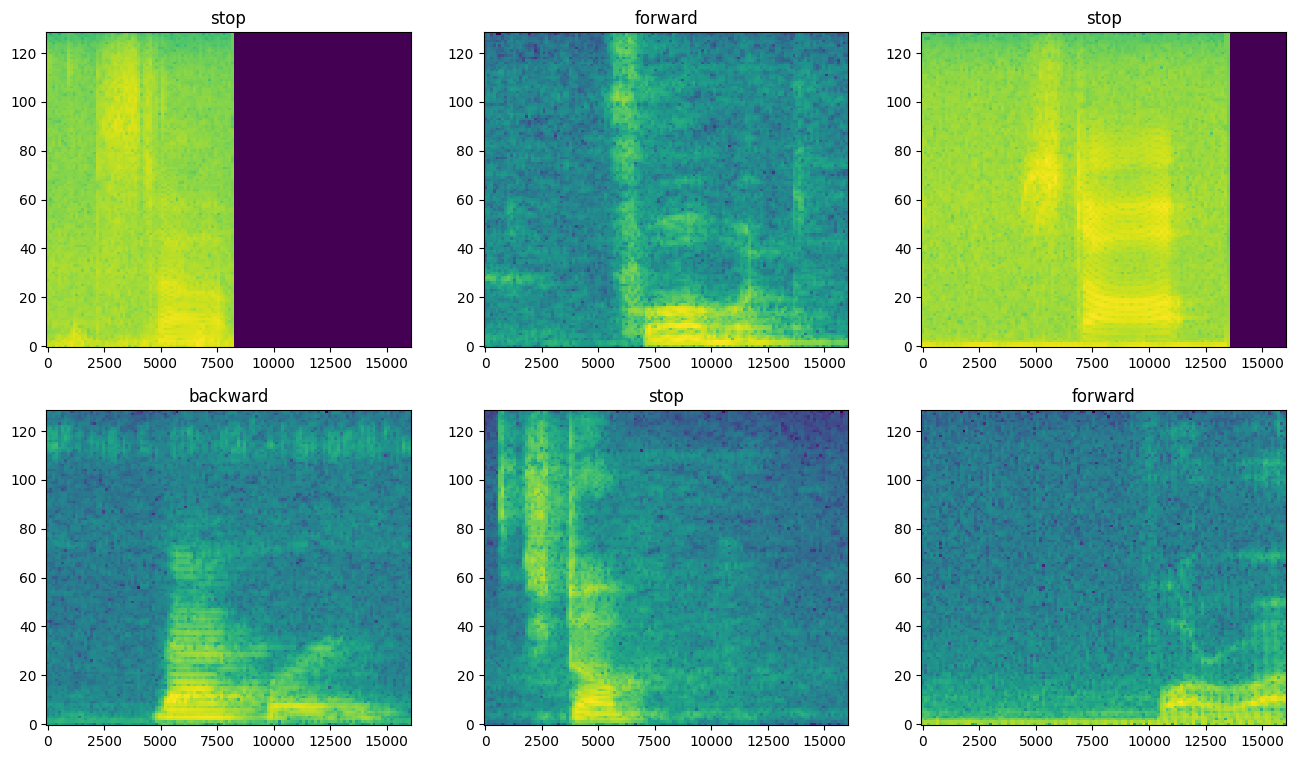

In [30]:
rows = 2
cols = 3
n = rows*cols
fig, axes = plt.subplots(rows, cols, figsize=(16, 9))

for i in range(n):
    r = i // cols
    c = i % cols
    ax = axes[r][c]
    plot_spectrogram(example_spectrograms[i].numpy(), ax)
    ax.set_title(label_names[example_spect_labels[i].numpy()])

plt.show()

### `Dataset.cache` and `Dataset.prefetch` operations to reduce read latency while training the model:

In [31]:
train_spectrogram_ds = train_spectrogram_ds.cache().shuffle(10000).prefetch(tf.data.AUTOTUNE)
val_spectrogram_ds = val_spectrogram_ds.cache().prefetch(tf.data.AUTOTUNE)
test_spectrogram_ds = test_spectrogram_ds.cache().prefetch(tf.data.AUTOTUNE)

In [34]:
input_shape = example_spectrograms.shape[1:]
print('Input shape:', input_shape)
num_labels = len(label_names)
norm_layer = layers.Normalization()
norm_layer.adapt(data=train_spectrogram_ds.map(map_func=lambda spec, label: spec))

Input shape: (124, 129, 1)


## Model 1

In [28]:


model = models.Sequential([
    layers.Input(shape=input_shape),
    # Downsample the input.
    layers.Resizing(32, 32),
    # Normalize.
    norm_layer,
    layers.Conv2D(32, 3, activation='relu'),
    layers.Conv2D(64, 3, activation='relu'),
    layers.MaxPooling2D(),
    layers.Dropout(0.25),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(num_labels),
])

model.summary()

Input shape: (124, 129, 1)
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resizing (Resizing)         (None, 32, 32, 1)         0         
                                                                 
 normalization (Normalizati  (None, 32, 32, 1)         3         
 on)                                                             
                                                                 
 conv2d (Conv2D)             (None, 30, 30, 32)        320       
                                                                 
 conv2d_1 (Conv2D)           (None, 28, 28, 64)        18496     
                                                                 
 max_pooling2d (MaxPooling2  (None, 14, 14, 64)        0         
 D)                                                              
                                                                 
 dropout (Dropout)           

### Keras model with the Adam optimizer and the cross-entropy loss:

In [29]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy'],
)

### Train the model

In [30]:
EPOCHS = 10
history = model.fit(
    train_spectrogram_ds,
    validation_data=val_spectrogram_ds,
    epochs=EPOCHS,
    callbacks=tf.keras.callbacks.EarlyStopping(verbose=1, patience=2),
)

Epoch 1/10
75/75 [==============================] - 22s 252ms/step - loss: 1.4155 - accuracy: 0.4696 - val_loss: 0.9403 - val_accuracy: 0.6858
Epoch 2/10
75/75 [==============================] - 18s 233ms/step - loss: 0.8772 - accuracy: 0.7100 - val_loss: 0.5882 - val_accuracy: 0.8264
Epoch 3/10
75/75 [==============================] - 18s 236ms/step - loss: 0.6186 - accuracy: 0.8021 - val_loss: 0.4402 - val_accuracy: 0.8698
Epoch 4/10
75/75 [==============================] - 17s 229ms/step - loss: 0.4736 - accuracy: 0.8396 - val_loss: 0.3587 - val_accuracy: 0.8941
Epoch 5/10
75/75 [==============================] - 17s 232ms/step - loss: 0.3905 - accuracy: 0.8731 - val_loss: 0.3505 - val_accuracy: 0.8837
Epoch 6/10
75/75 [==============================] - 18s 237ms/step - loss: 0.3270 - accuracy: 0.8927 - val_loss: 0.3047 - val_accuracy: 0.9045
Epoch 7/10
75/75 [==============================] - 18s 244ms/step - loss: 0.2757 - accuracy: 0.9115 - val_loss: 0.2653 - val_accuracy: 0.9201

### Plot the training and validation loss curves to check how your model has improved during training:

Text(0, 0.5, 'Accuracy [%]')

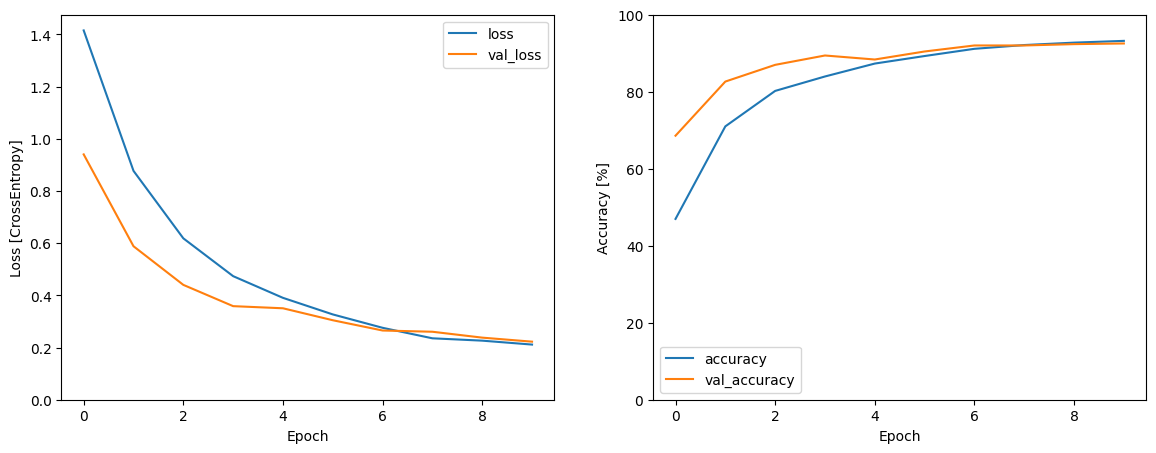

In [31]:
metrics = history.history
plt.figure(figsize=(14,5))
plt.subplot(1,2,1)
plt.plot(history.epoch, metrics['loss'], metrics['val_loss'])
plt.legend(['loss', 'val_loss'])
plt.ylim([0, max(plt.ylim())])
plt.xlabel('Epoch')
plt.ylabel('Loss [CrossEntropy]')

plt.subplot(1,2,2)
plt.plot(history.epoch, 100*np.array(metrics['accuracy']), 100*np.array(metrics['val_accuracy']))
plt.legend(['accuracy', 'val_accuracy'])
plt.ylim([0, 100])
plt.xlabel('Epoch')
plt.ylabel('Accuracy [%]')

### Evaluate the model performance

Run the model on the test set and check the model's performance:

In [32]:
model.evaluate(test_spectrogram_ds, return_dict=True)

10/10 [==============================] - 1s 59ms/step - loss: 0.3075 - accuracy: 0.9071


{'loss': 0.3075125515460968, 'accuracy': 0.9070512652397156}

### Display a confusion matrix

In [33]:
y_pred = model.predict(test_spectrogram_ds)

10/10 [==============================] - 1s 42ms/step


In [34]:
y_pred = tf.argmax(y_pred, axis=1)

In [35]:
y_true = tf.concat(list(test_spectrogram_ds.map(lambda s,lab: lab)), axis=0)

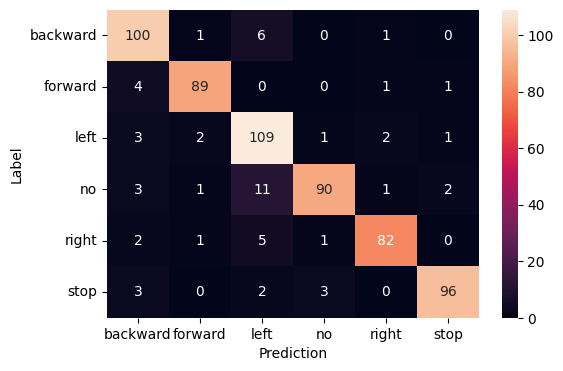

In [36]:
confusion_mtx = tf.math.confusion_matrix(y_true, y_pred)
plt.figure(figsize=(6, 4))
sns.heatmap(confusion_mtx,
            xticklabels=label_names,
            yticklabels=label_names,
            annot=True, fmt='g')
plt.xlabel('Prediction')
plt.ylabel('Label')
plt.show()

### Export the model with preprocessing

In [37]:
class ExportModel(tf.Module):
  def __init__(self, model):
    self.model = model

    # Accept either a string-filename or a batch of waveforms.
    # YOu could add additional signatures for a single wave, or a ragged-batch.
    self.__call__.get_concrete_function(
        x=tf.TensorSpec(shape=(), dtype=tf.string))
    self.__call__.get_concrete_function(
       x=tf.TensorSpec(shape=[None, 16000], dtype=tf.float32))


  @tf.function
  def __call__(self, x):
    # If they pass a string, load the file and decode it.
    if x.dtype == tf.string:
      x = tf.io.read_file(x)
      x, _ = tf.audio.decode_wav(x, desired_channels=1, desired_samples=16000,)
      x = tf.squeeze(x, axis=-1)
      x = x[tf.newaxis, :]

    x = get_spectrogram(x)
    result = self.model(x, training=False)

    class_ids = tf.argmax(result, axis=-1)
    class_names = tf.gather(label_names, class_ids)
    return {'predictions':result,
            'class_ids': class_ids,
            'class_names': class_names}

## Model 2

In [38]:
model2 = models.Sequential([
    layers.Input(shape=input_shape),
    layers.Resizing(32, 32),
    norm_layer,
    layers.Conv2D(32, 3, activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPooling2D(),
    layers.Conv2D(64, 3, activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPooling2D(),
    layers.Dropout(0.25),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(num_labels),
])


In [39]:
model2.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resizing_1 (Resizing)       (None, 32, 32, 1)         0         
                                                                 
 normalization (Normalizati  (None, 32, 32, 1)         3         
 on)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 30, 30, 32)        320       
                                                                 
 batch_normalization (Batch  (None, 30, 30, 32)        128       
 Normalization)                                                  
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 15, 15, 32)        0         
 g2D)                                                            
                                                      

In [40]:
model2.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy'],
)

timizer=tf.keras.optimizers.Adam(),
loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),


In [41]:
EPOCHS = 10
history = model2.fit(
    train_spectrogram_ds,
    validation_data=val_spectrogram_ds,
    epochs=EPOCHS,
    callbacks=tf.keras.callbacks.EarlyStopping(verbose=1, patience=2),
)

Epoch 1/10
75/75 [==============================] - 12s 112ms/step - loss: 1.8865 - accuracy: 0.3775 - val_loss: 1.6372 - val_accuracy: 0.3299
Epoch 2/10
75/75 [==============================] - 9s 126ms/step - loss: 1.1533 - accuracy: 0.5681 - val_loss: 1.5004 - val_accuracy: 0.3750
Epoch 3/10
75/75 [==============================] - 9s 123ms/step - loss: 0.8942 - accuracy: 0.6752 - val_loss: 1.4628 - val_accuracy: 0.3889
Epoch 4/10
75/75 [==============================] - 7s 98ms/step - loss: 0.6965 - accuracy: 0.7500 - val_loss: 1.2506 - val_accuracy: 0.4809
Epoch 5/10
75/75 [==============================] - 9s 119ms/step - loss: 0.5510 - accuracy: 0.8015 - val_loss: 0.9574 - val_accuracy: 0.6128
Epoch 6/10
75/75 [==============================] - 9s 122ms/step - loss: 0.4625 - accuracy: 0.8342 - val_loss: 0.8641 - val_accuracy: 0.6701
Epoch 7/10
75/75 [==============================] - 9s 119ms/step - loss: 0.4139 - accuracy: 0.8567 - val_loss: 0.7056 - val_accuracy: 0.7344
Epoch 

Text(0, 0.5, 'Accuracy [%]')

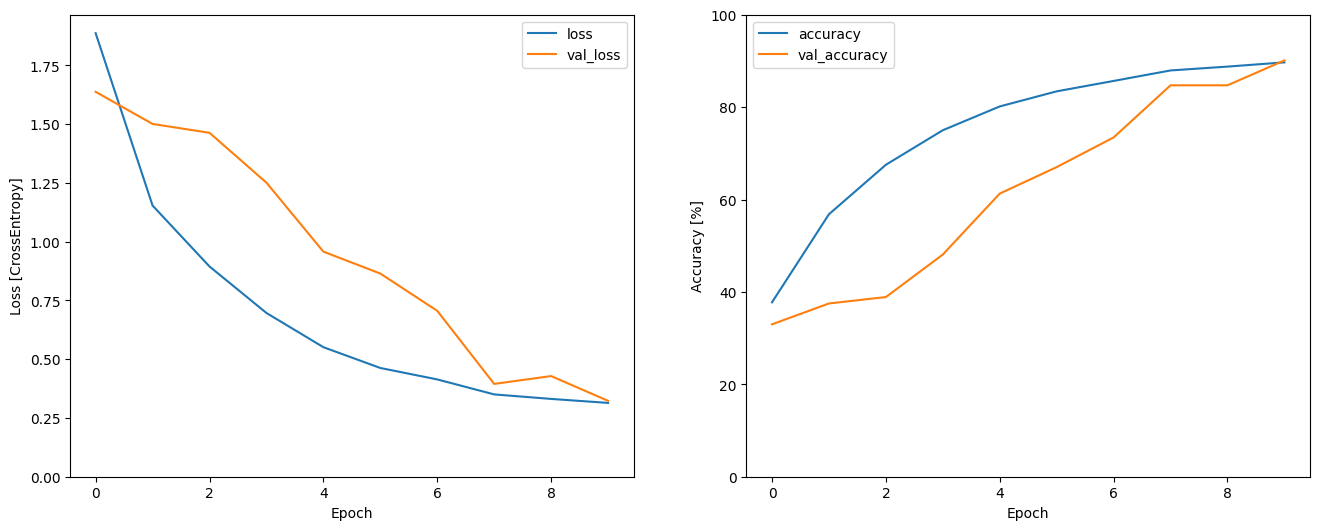

In [42]:
metrics = history.history
plt.figure(figsize=(16,6))
plt.subplot(1,2,1)
plt.plot(history.epoch, metrics['loss'], metrics['val_loss'])
plt.legend(['loss', 'val_loss'])
plt.ylim([0, max(plt.ylim())])
plt.xlabel('Epoch')
plt.ylabel('Loss [CrossEntropy]')

plt.subplot(1,2,2)
plt.plot(history.epoch, 100*np.array(metrics['accuracy']), 100*np.array(metrics['val_accuracy']))
plt.legend(['accuracy', 'val_accuracy'])
plt.ylim([0, 100])
plt.xlabel('Epoch')
plt.ylabel('Accuracy [%]')

### Evaluate the model

In [43]:
model2.evaluate(test_spectrogram_ds, return_dict=True)

10/10 [==============================] - 0s 37ms/step - loss: 0.3908 - accuracy: 0.8686


{'loss': 0.39076822996139526, 'accuracy': 0.8685897588729858}

In [44]:
y_pred = model2.predict(test_spectrogram_ds)
y_pred = tf.argmax(y_pred, axis=1)

10/10 [==============================] - 1s 32ms/step


In [45]:
y_true = tf.concat(list(test_spectrogram_ds.map(lambda s,lab: lab)), axis=0)

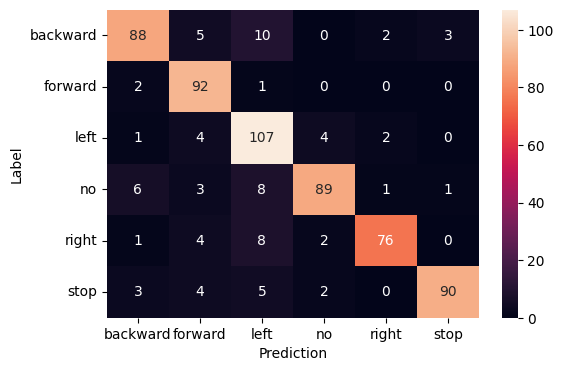

In [46]:
confusion_mtx = tf.math.confusion_matrix(y_true, y_pred)
plt.figure(figsize=(6, 4))
sns.heatmap(confusion_mtx,
            xticklabels=label_names,
            yticklabels=label_names,
            annot=True, fmt='g')
plt.xlabel('Prediction')
plt.ylabel('Label')
plt.show()

## Model 3

In [35]:
model3 = models.Sequential([
    layers.Input(shape=input_shape),
    layers.Conv2D(32, 3, activation='relu', dilation_rate=(2, 2)),
    layers.MaxPooling2D(),
    layers.Conv2D(64, 3, activation='relu', dilation_rate=(2, 2)),
    layers.MaxPooling2D(),
    layers.Conv2D(128, 3, activation='relu', dilation_rate=(2, 2)),
    layers.GlobalAveragePooling2D(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(num_labels),
])


In [36]:
model3.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 120, 125, 32)      320       
                                                                 
 max_pooling2d (MaxPooling2  (None, 60, 62, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 56, 58, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 28, 29, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 24, 25, 128)       73856     
                                                                 
 global_average_pooling2d (  (None, 128)               0

In [49]:
model3.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy'],
)

In [50]:
EPOCHS = 10
history = model3.fit(
    train_spectrogram_ds,
    validation_data=val_spectrogram_ds,
    epochs=EPOCHS,
    callbacks=tf.keras.callbacks.EarlyStopping(verbose=1, patience=2),
)

Epoch 1/10


2024-02-01 15:16:22.274667: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 123863040 exceeds 10% of free system memory.
2024-02-01 15:16:22.436781: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 122880000 exceeds 10% of free system memory.
2024-02-01 15:16:24.114291: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 122880000 exceeds 10% of free system memory.
2024-02-01 15:16:24.430372: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 123863040 exceeds 10% of free system memory.


 1/75 [..............................] - ETA: 9:12 - loss: 1.7906 - accuracy: 0.1719

2024-02-01 15:16:24.764710: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 123863040 exceeds 10% of free system memory.


75/75 [==============================] - 116s 1s/step - loss: 1.7079 - accuracy: 0.2735 - val_loss: 1.5738 - val_accuracy: 0.2951
Epoch 2/10
75/75 [==============================] - 80s 1s/step - loss: 1.5431 - accuracy: 0.3879 - val_loss: 1.3452 - val_accuracy: 0.5139
Epoch 3/10
75/75 [==============================] - 68s 909ms/step - loss: 1.3347 - accuracy: 0.5023 - val_loss: 1.1139 - val_accuracy: 0.5990
Epoch 4/10
75/75 [==============================] - 69s 916ms/step - loss: 1.0667 - accuracy: 0.6192 - val_loss: 0.9391 - val_accuracy: 0.6979
Epoch 5/10
75/75 [==============================] - 151s 2s/step - loss: 0.8721 - accuracy: 0.7000 - val_loss: 0.6986 - val_accuracy: 0.8090
Epoch 6/10
75/75 [==============================] - 152s 2s/step - loss: 0.7484 - accuracy: 0.7462 - val_loss: 0.6169 - val_accuracy: 0.8472
Epoch 7/10
75/75 [==============================] - 100s 1s/step - loss: 0.6336 - accuracy: 0.8085 - val_loss: 0.5407 - val_accuracy: 0.8733
Epoch 8/10
75/75 [===

Text(0, 0.5, 'Accuracy [%]')

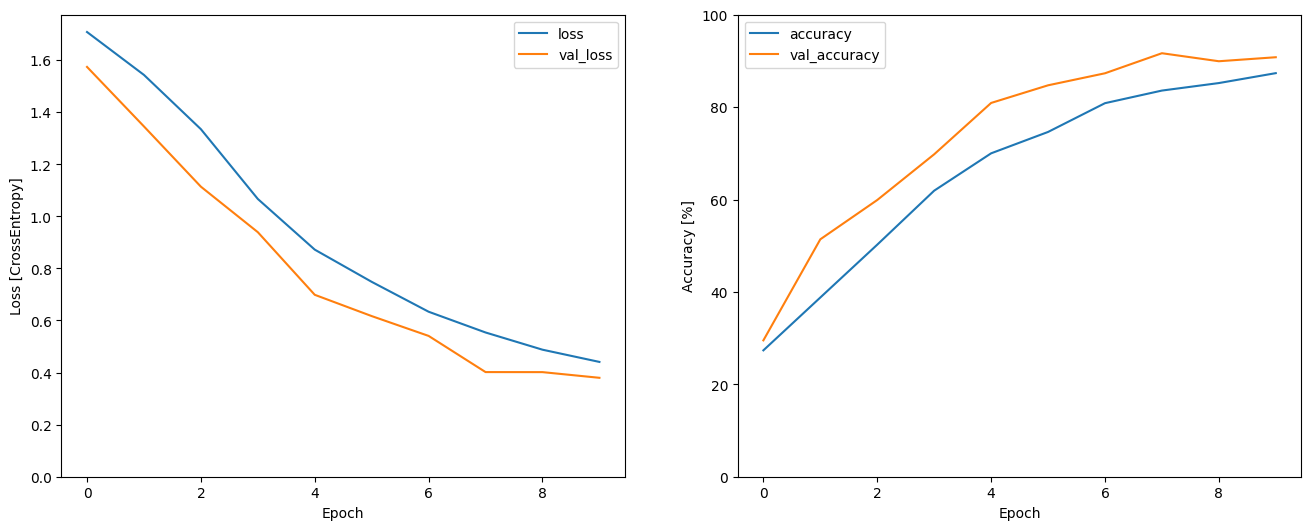

In [51]:
metrics = history.history
plt.figure(figsize=(16,6))
plt.subplot(1,2,1)
plt.plot(history.epoch, metrics['loss'], metrics['val_loss'])
plt.legend(['loss', 'val_loss'])
plt.ylim([0, max(plt.ylim())])
plt.xlabel('Epoch')
plt.ylabel('Loss [CrossEntropy]')

plt.subplot(1,2,2)
plt.plot(history.epoch, 100*np.array(metrics['accuracy']), 100*np.array(metrics['val_accuracy']))
plt.legend(['accuracy', 'val_accuracy'])
plt.ylim([0, 100])
plt.xlabel('Epoch')
plt.ylabel('Accuracy [%]')

### Evaluate the model

In [52]:
model3.evaluate(test_spectrogram_ds, return_dict=True)

10/10 [==============================] - 3s 265ms/step - loss: 0.4111 - accuracy: 0.8942


{'loss': 0.411091148853302, 'accuracy': 0.8942307829856873}

In [53]:
y_pred = model3.predict(test_spectrogram_ds)
y_pred = tf.argmax(y_pred, axis=1)

10/10 [==============================] - 3s 268ms/step


In [54]:
y_true = tf.concat(list(test_spectrogram_ds.map(lambda s,lab: lab)), axis=0)

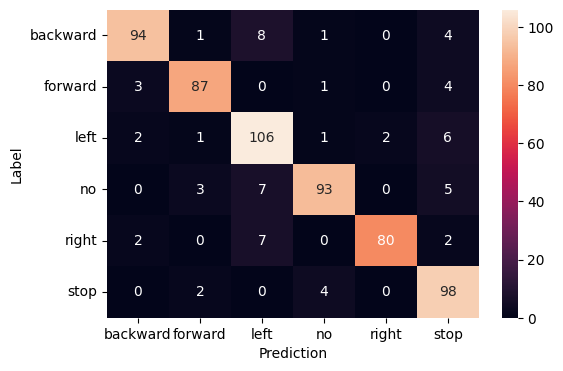

In [55]:
confusion_mtx = tf.math.confusion_matrix(y_true, y_pred)
plt.figure(figsize=(6, 4))
sns.heatmap(confusion_mtx,
            xticklabels=label_names,
            yticklabels=label_names,
            annot=True, fmt='g')
plt.xlabel('Prediction')
plt.ylabel('Label')
plt.show()

## Model 4

In [56]:

train_spectrogram_ds = train_spectrogram_ds.map(lambda x, y: (tf.image.grayscale_to_rgb(x), y))
val_spectrogram_ds = val_spectrogram_ds.map(lambda x, y: (tf.image.grayscale_to_rgb(x), y))

In [57]:
input_shape = (124, 129, 3) 
base_model = tf.keras.applications.MobileNetV2(
    input_shape=input_shape, include_top=False, weights='imagenet')
base_model.trainable = False

model4 = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(num_labels),
])


In [58]:
model4.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenetv2_1.00_224 (Func  (None, 4, 5, 1280)        2257984   
 tional)                                                         
                                                                 
 global_average_pooling2d_1  (None, 1280)              0         
  (GlobalAveragePooling2D)                                       
                                                                 
 dense_6 (Dense)             (None, 128)               163968    
                                                                 
 dropout_5 (Dropout)         (None, 128)               0         
                                                                 
 dense_7 (Dense)             (None, 6)                 774       
                                                                 
Total params: 2422726 (9.24 MB)
Trainable params: 1647

In [59]:
model4.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy'],
)

In [60]:
EPOCHS = 10
history = model4.fit(
    train_spectrogram_ds,
    validation_data=val_spectrogram_ds,
    epochs=EPOCHS,
    callbacks=tf.keras.callbacks.EarlyStopping(verbose=1, patience=2),
)

Epoch 1/10
75/75 [==============================] - 28s 326ms/step - loss: 1.4884 - accuracy: 0.4335 - val_loss: 0.9806 - val_accuracy: 0.6823
Epoch 2/10
75/75 [==============================] - 25s 334ms/step - loss: 1.0601 - accuracy: 0.6098 - val_loss: 0.7838 - val_accuracy: 0.7378
Epoch 3/10
75/75 [==============================] - 25s 328ms/step - loss: 0.8819 - accuracy: 0.6792 - val_loss: 0.6757 - val_accuracy: 0.7760
Epoch 4/10
75/75 [==============================] - 25s 335ms/step - loss: 0.8024 - accuracy: 0.7133 - val_loss: 0.6608 - val_accuracy: 0.7674
Epoch 5/10
75/75 [==============================] - 25s 333ms/step - loss: 0.7239 - accuracy: 0.7385 - val_loss: 0.6005 - val_accuracy: 0.8003
Epoch 6/10
75/75 [==============================] - 26s 347ms/step - loss: 0.6715 - accuracy: 0.7581 - val_loss: 0.5638 - val_accuracy: 0.8021
Epoch 7/10
75/75 [==============================] - 24s 324ms/step - loss: 0.6088 - accuracy: 0.7750 - val_loss: 0.5548 - val_accuracy: 0.8142

Text(0, 0.5, 'Accuracy [%]')

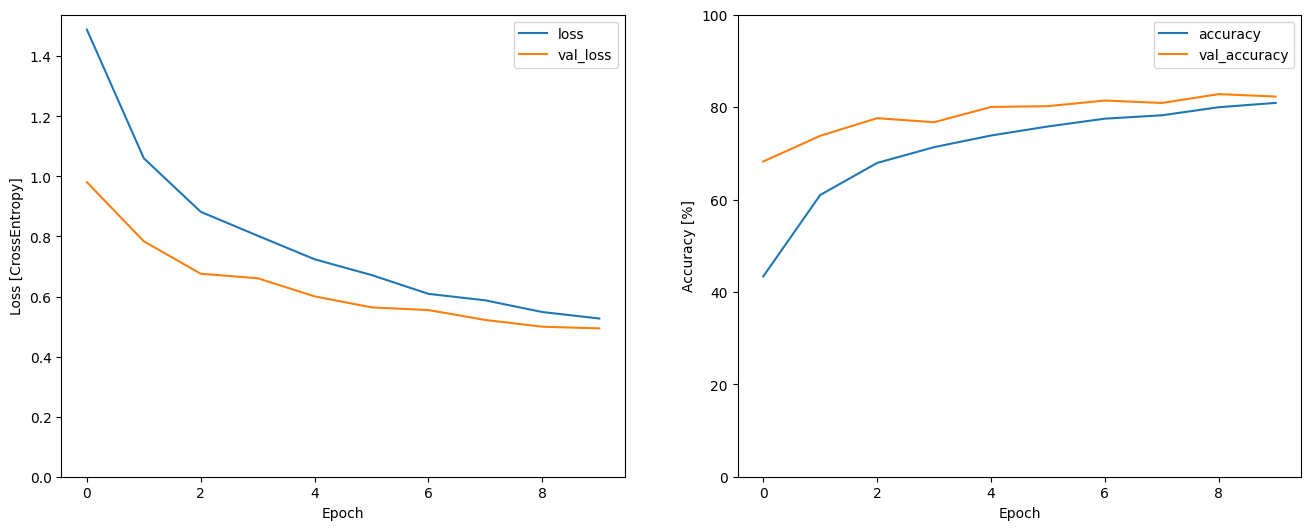

In [61]:
metrics = history.history
plt.figure(figsize=(16,6))
plt.subplot(1,2,1)
plt.plot(history.epoch, metrics['loss'], metrics['val_loss'])
plt.legend(['loss', 'val_loss'])
plt.ylim([0, max(plt.ylim())])
plt.xlabel('Epoch')
plt.ylabel('Loss [CrossEntropy]')

plt.subplot(1,2,2)
plt.plot(history.epoch, 100*np.array(metrics['accuracy']), 100*np.array(metrics['val_accuracy']))
plt.legend(['accuracy', 'val_accuracy'])
plt.ylim([0, 100])
plt.xlabel('Epoch')
plt.ylabel('Accuracy [%]')

### Evaluate the model

In [62]:
model4.evaluate(val_spectrogram_ds, return_dict=True)


9/9 [==============================] - 3s 327ms/step - loss: 0.4939 - accuracy: 0.8229


{'loss': 0.493881493806839, 'accuracy': 0.8229166865348816}

In [63]:
y_pred = model4.predict(val_spectrogram_ds)
y_pred = tf.argmax(y_pred, axis=1)

9/9 [==============================] - 4s 291ms/step


In [64]:
y_true = tf.concat(list(val_spectrogram_ds.map(lambda s,lab: lab)), axis=0)

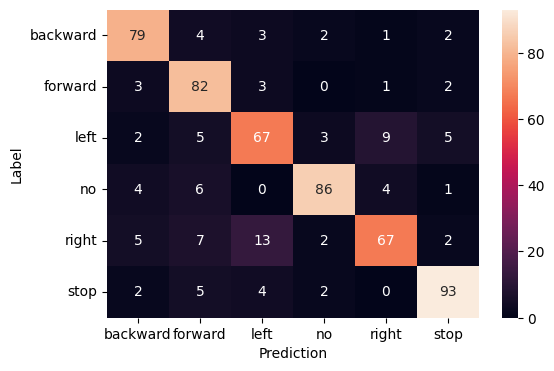

In [65]:
confusion_mtx = tf.math.confusion_matrix(y_true, y_pred)
plt.figure(figsize=(6, 4))
sns.heatmap(confusion_mtx,
            xticklabels=label_names,
            yticklabels=label_names,
            annot=True, fmt='g')
plt.xlabel('Prediction')
plt.ylabel('Label')
plt.show()

# Exporting a model

## Export the model with preprocessing

In [66]:
class ExportModel(tf.Module):
  def __init__(self, model):
    self.model = model

    # Accept either a string-filename or a batch of waveforms.
    # YOu could add additional signatures for a single wave, or a ragged-batch.
    self.__call__.get_concrete_function(
        x=tf.TensorSpec(shape=(), dtype=tf.string))
    self.__call__.get_concrete_function(
       x=tf.TensorSpec(shape=[None, 16000], dtype=tf.float32))


  @tf.function
  def __call__(self, x):
    # If they pass a string, load the file and decode it.
    if x.dtype == tf.string:
      x = tf.io.read_file(x)
      x, _ = tf.audio.decode_wav(x, desired_channels=1, desired_samples=16000,)
      x = tf.squeeze(x, axis=-1)
      x = x[tf.newaxis, :]

    x = get_spectrogram(x)
    result = self.model(x, training=False)

    class_ids = tf.argmax(result, axis=-1)
    class_names = tf.gather(label_names, class_ids)
    return {'predictions':result,
            'class_ids': class_ids,
            'class_names': class_names}

In [69]:
export = ExportModel(model)
export(tf.constant(str('dataset/backward/0165e0e8_nohash_0.wav')))

{'predictions': <tf.Tensor: shape=(1, 6), dtype=float32, numpy=
 array([[ 0.89707416, -1.6854091 ,  1.3895328 , -1.4053223 ,  0.26081938,
         -0.19512078]], dtype=float32)>,
 'class_ids': <tf.Tensor: shape=(1,), dtype=int64, numpy=array([2])>,
 'class_names': <tf.Tensor: shape=(1,), dtype=string, numpy=array([b'left'], dtype=object)>}

Save and reload the model, the reloaded model gives identical output:

In [70]:
tf.saved_model.save(export, "saved")
imported = tf.saved_model.load("saved")
imported(waveform[tf.newaxis, :])

INFO:tensorflow:Assets written to: saved/assets


INFO:tensorflow:Assets written to: saved/assets


{'class_ids': <tf.Tensor: shape=(1,), dtype=int64, numpy=array([0])>,
 'class_names': <tf.Tensor: shape=(1,), dtype=string, numpy=array([b'backward'], dtype=object)>,
 'predictions': <tf.Tensor: shape=(1, 6), dtype=float32, numpy=
 array([[ 4.7195272 , -0.34679338, -0.502134  , -0.8088891 ,  0.03239011,
         -1.9983392 ]], dtype=float32)>}